# Stress Testing of Portfolio Returns

This notebook demonstrates how to perform stress testing on historical price data using Monte Carlo simulations.  
In these simulations, we generate multiple potential future paths for asset returns and compute risk measures such as Value at Risk (VaR).

**Steps:**
1. **Data Loading:** Upload and load the cleaned historical price data.
2. **Return Calculation:** Compute weekly returns.
3. **Monte Carlo Simulation:** Generate simulated paths using adjusted (stressed) mean returns and covariance matrices.
4. **VaR Calculation:** Compute the 5% Value at Risk (VaR) for the first asset.
5. **Visualization:** Plot simulation paths for each stress scenario.


before you proceed, take a look at the glossary:

## Technical Glossary:
- **VaR (Value at Risk):** A risk measure estimating the maximum expected loss over a given period at a specified confidence level.
- **Monte Carlo Simulation:** A computational algorithm that uses repeated random sampling to simulate the behavior of a system.

In [ ]:
# importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set visual style for plots

sns.set(style="whitegrid", context="talk", palette="deep")



Libraries imported successfully!


In [ ]:
from google.colab import files

# Upload the processed CSV file (e.g., historical_prices_cleaned.csv)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the cleaned price data
prices = pd.read_csv(filename, index_col=0, parse_dates=True)
print("Price Data (first 5 rows):")
print(prices.head())

# ## Compute Weekly Returns, that are calculated as the percentage change in prices from one week to the next.

def compute_returns(prices):
    returns = prices.pct_change(fill_method=None).dropna()
    return returns

returns = compute_returns(prices)
print("Weekly Returns (first 5 rows):")
print(returns.head())


Saving historical_prices_cleaned.csv to historical_prices_cleaned (1).csv
Price Data (first 5 rows):
              AMZN         GE      GOOGL        HSY        MMM       MSFT  \
Date                                                                        
2012-01-01  9.1305  69.240280  16.208012  44.837509  46.040127  22.132902   
2012-01-08  8.9210  69.945709  15.583897  45.421150  46.167137  22.243130   
2012-01-15  9.5465  71.096581  14.611446  45.465488  47.299232  23.392693   
2012-01-22  9.7685  70.651070  14.461590  45.243847  48.298786  23.014755   
2012-01-29  9.3840  70.613945  14.869270  45.184734  48.447895  23.809998   

                  SHY  
Date                   
2012-01-01  71.186943  
2012-01-08  71.245903  
2012-01-15  71.229073  
2012-01-22  71.304886  
2012-01-29  71.237541  
Weekly Returns (first 5 rows):
                AMZN        GE     GOOGL       HSY       MMM      MSFT  \
Date                                                                     
2012-01-08 -

## Monte Carlo Simulation

We simulate future asset returns using a multivariate normal distribution.  
Parameters:
- **num_simulations:** Number of simulation runs.
- **time_horizon:** Number of weeks to simulate.
- **scale_returns / scale_cov:** Multipliers to adjust (stress) the mean returns and covariance.

Each simulation produces cumulative return paths by computing the cumulative product of (1 + simulated return).

In [ ]:
def monte_carlo_simulation(returns, num_simulations=5000, time_horizon=52, scale_returns=1.0, scale_cov=1.0):

    np.random.seed(42)
    sim_results = []
    mean_ret = returns.mean() * scale_returns
    cov_matrix = returns.cov() * scale_cov
    num_assets = returns.shape[1]

    for _ in range(num_simulations):
        # Draw simulated weekly returns for all assets
        sim = np.random.multivariate_normal(mean_ret, cov_matrix, time_horizon)
        # Calculate cumulative returns for each asset (simple cumulative product)
        sim_cum = (sim + 1).cumprod(axis=0)
        sim_results.append(sim_cum)
    return np.array(sim_results)

# Test the function for baseline scenario
sim_baseline = monte_carlo_simulation(returns, num_simulations=1000, time_horizon=52, scale_returns=1.0, scale_cov=1.0)
print("Baseline simulation shape:", sim_baseline.shape)


Baseline simulation shape: (1000, 52, 7)


## Value at Risk (VaR) Calculation

The VaR is computed by taking the 5th percentile of the simulated final cumulative returns for a selected asset.

In [ ]:

def compute_var(simulations, asset_index=0, confidence_level=5):

    final_returns = simulations[:, -1, asset_index]
    var = np.percentile(final_returns, confidence_level)
    return var

# Define different stress scenarios
scenarios = {
    "Baseline": {"scale_returns": 1.0, "scale_cov": 1.0},
    "Market Crash": {"scale_returns": 0.5, "scale_cov": 1.0},
    "High Volatility": {"scale_returns": 1.0, "scale_cov": 2.0},
    "Combined Stress": {"scale_returns": 0.5, "scale_cov": 2.0}
}

scenario_results = {}
for name, params in scenarios.items():
    sims = monte_carlo_simulation(returns, num_simulations=1000, time_horizon=52,
                                  scale_returns=params["scale_returns"],
                                  scale_cov=params["scale_cov"])
    var_95 = compute_var(sims, asset_index=0, confidence_level=5)
    scenario_results[name] = {"simulations": sims, "VaR_5%": var_95}
    print(f"{name} Scenario - 5% VaR for first asset: {var_95:.4f}")


Baseline Scenario - 5% VaR for first asset: 0.7903
Market Crash Scenario - 5% VaR for first asset: 0.6866
High Volatility Scenario - 5% VaR for first asset: 0.6166
Combined Stress Scenario - 5% VaR for first asset: 0.5352


## Visualization of Simulation Paths

For each scenario, we plot a subset of the simulation paths for the first asset.


Baseline Scenario:


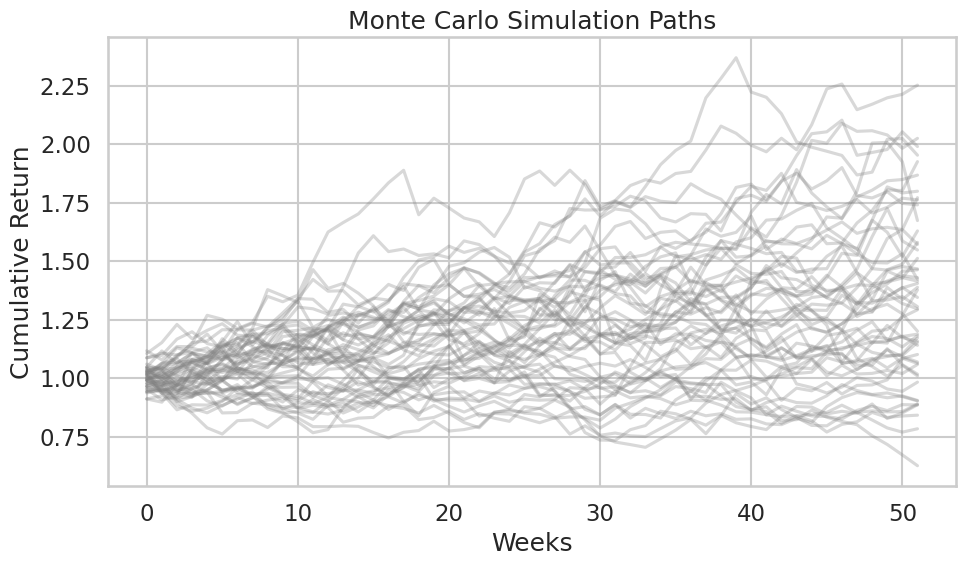


Market Crash Scenario:


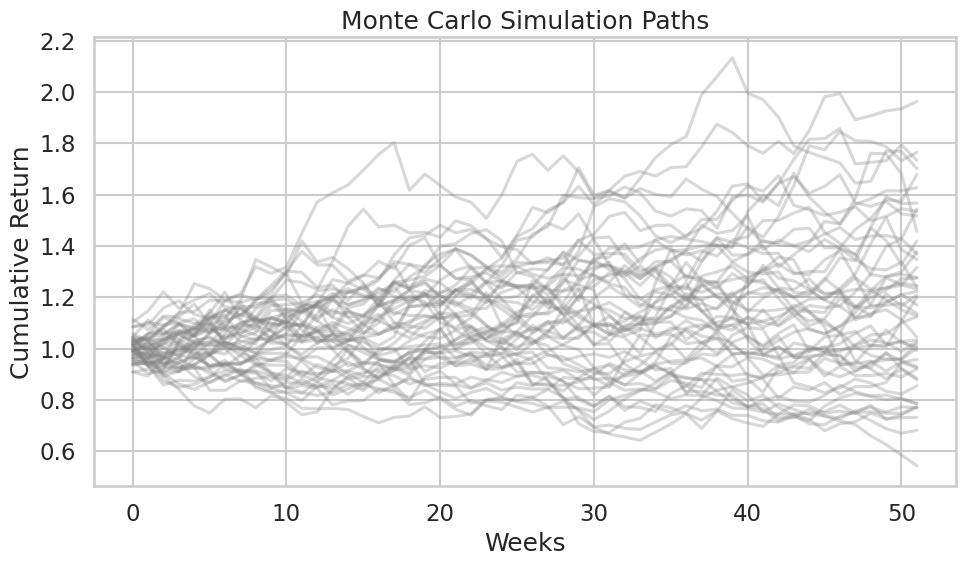


High Volatility Scenario:


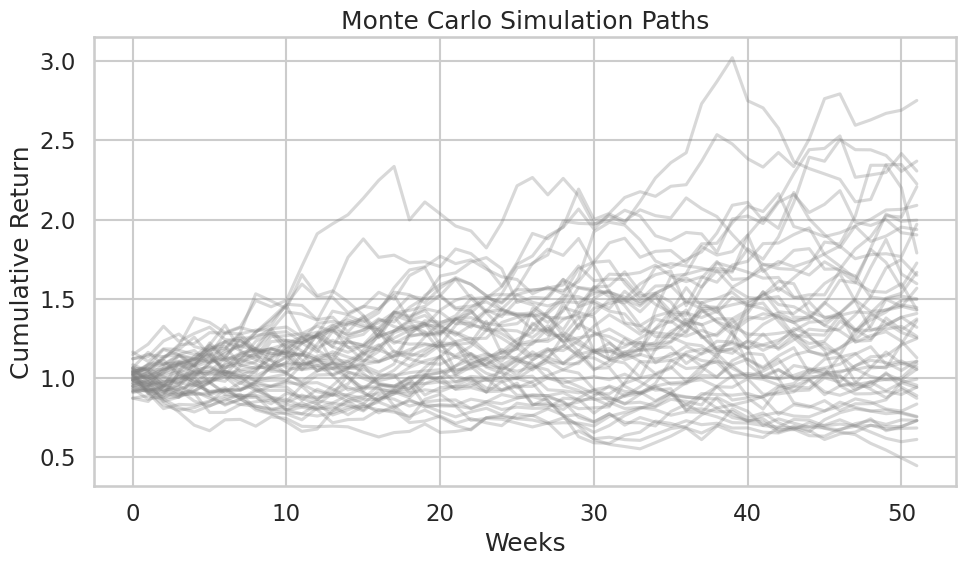


Combined Stress Scenario:


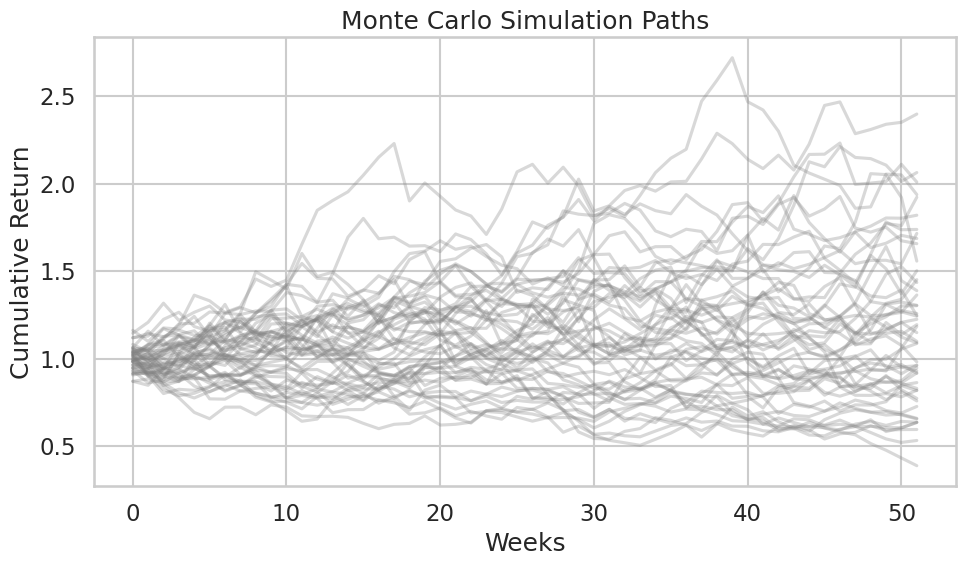

In [ ]:

def plot_simulation_paths(simulations, asset_index=0, num_paths=50):

    plt.figure(figsize=(10, 6))
    for sim in simulations[:num_paths]:
        plt.plot(sim[:, asset_index], color='gray', alpha=0.3)
    plt.xlabel("Weeks")
    plt.ylabel("Cumulative Return")
    plt.title("Monte Carlo Simulation Paths")
    plt.tight_layout()
    plt.show()

# Plot for each scenario (for the first asset)
for name, results in scenario_results.items():
    print(f"\n{name} Scenario:")
    plot_simulation_paths(results["simulations"], asset_index=0, num_paths=50)
